In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) 

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  93087
number of successfully processed smiles:  93087


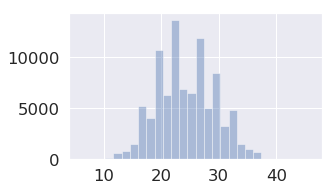

In [4]:
task_name = 'muv'
tasks = [
    "MUV-466","MUV-548","MUV-600","MUV-644","MUV-652","MUV-689","MUV-692","MUV-712","MUV-713","MUV-733","MUV-737","MUV-810","MUV-832","MUV-846","MUV-852","MUV-858","MUV-859"
]
raw_filename = "../data/muv.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.2
fingerprint_dim = 250

radius = 3
T = 2
weight_decay = 3.5 # also known as l2_regularization_lambda
learning_rate = 3.7
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
# uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

# smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as ../data/muv.pickle


,MUV-466,MUV-548,MUV-600,MUV-644,MUV-652,MUV-689,MUV-692,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859,mol_id,smiles,cano_smiles


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    negative_test = negative_df.sample(frac=1/10,random_state=random_seed)
    negative_valid = negative_df.drop(negative_test.index).sample(frac=1/9,random_state=random_seed)
    negative_train = negative_df.drop(negative_test.index).drop(negative_valid.index)
    
    positive_test = positive_df.sample(frac=1/10,random_state=random_seed)
    positive_valid = positive_df.drop(positive_test.index).sample(frac=1/9,random_state=random_seed)
    positive_train = positive_df.drop(positive_test.index).drop(positive_valid.index)
    
    weights.append([(positive_test.shape[0]+negative_test.shape[0])/negative_test.shape[0],\
                    (positive_test.shape[0]+negative_test.shape[0])/positive_test.shape[0]])
    train_df_new = pd.concat([negative_train,positive_train])
    valid_df_new = pd.concat([negative_valid,positive_valid])
    test_df_new = pd.concat([negative_test,positive_test])
    if i==0:
        train_df = train_df_new
        test_df = test_df_new
        valid_df = valid_df_new
    else:
        train_df = pd.merge(train_df, train_df_new, on='smiles', how='outer') 
        test_df = pd.merge(test_df, test_df_new, on='smiles', how='outer')
        valid_df = pd.merge(valid_df, valid_df_new, on='smiles', how='outer')

In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1790038
atom_fc.weight torch.Size([250, 39])
atom_fc.bias torch.Size([250])
neighbor_fc.weight torch.Size([250, 49])
neighbor_fc.bias torch.Size([250])
GRUCell.0.weight_ih torch.Size([750, 250])
GRUCell.0.weight_hh torch.Size([750, 250])
GRUCell.0.bias_ih torch.Size([750])
GRUCell.0.bias_hh torch.Size([750])
GRUCell.1.weight_ih torch.Size([750, 250])
GRUCell.1.weight_hh torch.Size([750, 250])
GRUCell.1.bias_ih torch.Size([750])
GRUCell.1.bias_hh torch.Size([750])
GRUCell.2.weight_ih torch.Size([750, 250])
GRUCell.2.weight_hh torch.Size([750, 250])
GRUCell.2.bias_ih torch.Size([750])
GRUCell.2.bias_hh torch.Size([750])
align.0.weight torch.Size([1, 500])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 500])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 500])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([250, 250])
attend.0.bias torch.Size([250])
attend.1.weight torch.Size([250, 250])
attend.1.bias torch.Size([250])
attend.2.weight torch.Size([250, 250]

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_prc, eval_loss # eval_precision, eval_recall, 


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_prc, train_loss = eval(model, train_df)
    valid_roc, valid_prc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    train_prc_mean = np.array(train_prc).mean()
    valid_prc_mean = np.array(valid_prc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.75:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        +"train_prc_mean"+":"+str(train_prc_mean)+'\n'\
        +"valid_prc_mean"+":"+str(valid_prc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >6) and (epoch - best_param["loss_epoch"] >8):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.42612659306044387, 0.617240512691631, 0.6308665731133413, 0.711857601713062, 0.36540520394479625, 0.5517446500630282, 0.5980674107651957, 0.43376758810842414, 0.667715234826656, 0.5768877361124035, 0.6747729715704808, 0.5262479733448362, 0.567303996925442, 0.516052930324961, 0.6243133348695802, 0.4565880843911717, 0.522737306843267]
valid_roc:[0.36506864731037586, 0.6603217765692273, 0.7942176870748299, 0.6790038839387708, 0.38780542479264735, 0.5465568519789521, 0.5067305498516997, 0.5048678720445062, 0.8570785505289218, 0.6375426621160409, 0.6066393815370623, 0.5740360483686973, 0.8711293260473589, 0.600817438692098, 0.4249886000911993, 0.11796610169491524, 0.6599864130434783]
train_roc_mean:0.5569232766275718
valid_roc_mean:0.576162189157693
train_prc_mean:0.002543257957516508
valid_prc_mean:0.005038454245508154

EPOCH:	1
train_roc:[0.6145557109107564, 0.7389973833212602, 0.4969772353574871, 0.7559885795860101, 0.6491338329490605, 0.6098667084368263, 0.60852505

In [11]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_prc, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
      +"\n"+"test_prc_mean:",str(np.array(test_prc).mean())
     )

best epoch:30
test_roc:[0.7069322529822194, 0.9920634920634926, 0.9140589569160998, 0.9497372629655017, 0.8429051782111639, 0.8650194463509492, 0.5133470225872684, 0.7204450625869266, 0.8113887013279318, 0.6747440273037547, 0.8958617553433379, 0.7577747378020971, 0.9988615664845174, 0.8921435059037236, 0.9952120383036938, 0.8998643147896877, 0.8939809782608699]
test_roc_mean: 0.8426082529519546
test_prc_mean: 0.22154438821952206
